 # BERT Fine-tuning for Named Entity Recognition (NER)

  This notebook implements fine-tuning of a pre-trained BERT model for Named Entity Recognition using the CoNLL-2003 format dataset. We'll use the DistilBERT model with custom loss functions and advanced training optimizations to achieve optimal NER performance.

  ## Setup: Import required libraries and dependencies

In [84]:
# %%

from notebook_config import FILES_DIR, DATASETS_DIR
import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
from transformers import (
    AutoTokenizer, 
    TrainingArguments, 
    Trainer,
    DataCollatorForTokenClassification,
    AutoConfig,
    EarlyStoppingCallback,
    AutoModelForTokenClassification as TokenClassifier
)
from sklearn.model_selection import train_test_split
import json
import pandas as pd
from evaluate import load
import matplotlib.pyplot as plt

# Try to import seqeval for better evaluation metrics
try:
    from seqeval.metrics import precision_score, recall_score, f1_score
    print("✓ seqeval available for advanced NER metrics")
except ImportError:
    print("⚠ seqeval not available. Install with: pip install seqeval")

✓ seqeval available for advanced NER metrics



 ## Define BIO Tag Label Mapping

  Create the label mapping for BIO (Begin-Inside-Outside) tagging scheme:

  **BIO Tag Structure:**
  - **B-**: Beginning of an entity
  - **I-**: Inside/continuation of an entity
  - **O**: Outside/not part of any entity

  **Entity Types:**
  - **PER**: Person names
  - **ORG**: Organization names
  - **LOC**: Location names
  - **MISC**: Miscellaneous entities

  This mapping ensures proper conversion between string labels and numeric IDs for model training.

In [85]:
# %%

# Define the label mapping for BIO tags
label2id = {
    'O': 0,
    'B-PER': 1, 'I-PER': 2,
    'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6
}

id2label = {v: k for k, v in label2id.items()}

print("Label mapping:")
for label, id_ in label2id.items():
    print(f"  {label}: {id_}")

Label mapping:
  O: 0
  B-PER: 1
  I-PER: 2
  B-ORG: 3
  I-ORG: 4
  B-LOC: 5
  I-LOC: 6



 ## Load and Parse CoNLL Format Data

  Load the NER annotations from the CoNLL-2003 format file created in the previous notebook:

  **CoNLL Format Structure:**
  - Each line contains: `token TAB label`
  - Empty lines separate sentences
  - Tokens are pre-tokenized and aligned with their entity labels

  **Data Validation:**
  - Checks for valid BIO tags
  - Handles malformed lines gracefully
  - Provides detailed error reporting for debugging

In [86]:
# %%

# Load and parse the CoNLL file
def load_conll_data(file_path):
    """Load data from CoNLL format file"""
    sentences = []
    current_sentence = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx,line in enumerate(f):
            line = line.strip()
            if line == "":
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    token = parts[0]
                    tag = parts[1]
                    if tag not in label2id:
                        print(f"About to do something stupid at line {idx}. The tag is ({tag})")
                    current_sentence.append((token, tag))
    
    # Add the last sentence if it exists
    if current_sentence:
        sentences.append(current_sentence)
    
    return sentences

# Load the CoNLL data
conll_file = DATASETS_DIR / "ner_annotations_combined.conll"
sentences = load_conll_data(conll_file)

print(f"Loaded {len(sentences)} sentences from CoNLL file")

# Show some examples
print("\nExample sentences:")
for i, sentence in enumerate(sentences[:2]):
    print(f"\nSentence {i+1}:")
    for token, tag in sentence[:10]:  # Show first 10 tokens
        print(f"  {token} -> {tag}")
    if len(sentence) > 10:
        print("  ...")

Loaded 11972 sentences from CoNLL file

Example sentences:

Sentence 1:
  Democrats -> O
  need -> O
  all -> O
  50 -> O
  of -> O
  their -> O
  senators -> O
  to -> O
  be -> O
  present -> O
  ...

Sentence 2:
  Manchin -> O
  told -> O
  CNN’s -> B-ORG
  Jake -> O
  Tapper -> B-PER
  on -> O
  “State -> O
  of -> O
  the -> O
  Union” -> O
  ...



 ## Prepare Data for Tokenization

  Convert the CoNLL format data into a format suitable for BERT tokenization:

  **Data Transformation:**
  - **Token extraction**: Separate tokens from their labels
  - **Text reconstruction**: Join tokens with spaces for BERT tokenization
  - **Label preservation**: Maintain corresponding label sequences

  This step prepares the data for the tokenization process while preserving the entity annotations.

In [87]:
# %%

# Prepare data for tokenization
def prepare_data_for_tokenization(sentences):
    """Convert sentences to format suitable for tokenization"""
    texts = []
    labels = []
    
    for sentence in sentences:
        tokens = [token for token, _ in sentence]
        tags = [tag for _, tag in sentence]
        
        # Join tokens with spaces for tokenization
        # text = " ".join(tokens)
        texts.append(tokens)
        labels.append(tags)
    
    return texts, labels

In [88]:
# %%

# Prepare the data
texts, labels = prepare_data_for_tokenization(sentences)

print(f"Prepared {len(texts)} texts for tokenization")

# Data validation - Check BIO consistency and label distribution
def validate_bio_consistency(labels):
    """Validate BIO tag consistency"""
    errors = []
    for i, sentence_labels in enumerate(labels):
        for j, label in enumerate(sentence_labels):
            # Check for invalid BIO patterns
            if j > 0:
                prev_label = sentence_labels[j-1]
                # I- tag cannot follow O tag
                if label.startswith('I-') and prev_label == 'O':
                    errors.append(f"Sentence {i}, token {j}: I- tag '{label}' follows O tag")
                # I- tag should match previous I- or B- tag
                if label.startswith('I-') and prev_label.startswith('I-'):
                    if label[2:] != prev_label[2:]:  # Different entity types
                        errors.append(f"Sentence {i}, token {j}: I- tag '{label}' follows different entity type '{prev_label}'")
    
    return errors

def analyze_label_distribution(labels):
    """Analyze label distribution"""
    label_counts = {}
    for sentence_labels in labels:
        for label in sentence_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
    
    total_tokens = sum(label_counts.values())
    print("\nLabel distribution:")
    for label, count in sorted(label_counts.items()):
        percentage = (count / total_tokens) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")
    
    return label_counts

# Validate data
print("\nValidating BIO consistency...")
bio_errors = validate_bio_consistency(labels)
if bio_errors:
    print(f"⚠ Found {len(bio_errors)} BIO consistency errors:")
    for error in bio_errors[:5]:  # Show first 5 errors
        print(f"  {error}")
    if len(bio_errors) > 5:
        print(f"  ... and {len(bio_errors) - 5} more errors")
else:
    print("✓ BIO consistency validation passed")

# Analyze label distribution
label_dist = analyze_label_distribution(labels)

Prepared 11972 texts for tokenization

Validating BIO consistency...
⚠ Found 96 BIO consistency errors:
  Sentence 141, token 15: I- tag 'I-ORG' follows O tag
  Sentence 556, token 5: I- tag 'I-LOC' follows O tag
  Sentence 679, token 44: I- tag 'I-LOC' follows O tag
  Sentence 780, token 22: I- tag 'I-ORG' follows O tag
  Sentence 898, token 6: I- tag 'I-ORG' follows different entity type 'I-LOC'
  ... and 91 more errors

Label distribution:
  B-LOC: 5396 (1.8%)
  B-ORG: 4957 (1.7%)
  B-PER: 5880 (2.0%)
  I-LOC: 1315 (0.4%)
  I-ORG: 3733 (1.3%)
  I-PER: 2909 (1.0%)
  O: 270830 (91.8%)



 ## Initialize BERT Tokenizer

  Set up the BERT tokenizer for text processing:

  **Model Selection:**
  - **dslim/distilbert-NER**: Pre-trained on NER tasks, optimized for entity recognition
  - **Cased tokenizer**: Preserves case information important for NER
  - **Specialized performance**: Better than generic BERT for NER tasks

  **Tokenizer Features:**
  - Handles subword tokenization
  - Manages special tokens (CLS, SEP, PAD)
  - Provides token-to-word mapping for label alignment

In [89]:
# %%

# Initialize tokenizer - use cased for better NER performance
# model_name = "bert-base-cased"  # Changed from uncased for better NER
model_name = "distilbert-base-cased"  # Use untrained base model
tokenizer = AutoTokenizer.from_pretrained(model_name)
# from notebooks.notebook_finetune_utils import DistilBertWithHingeLoss as TokenClassifier

print(f"Using tokenizer: {model_name}")

Using tokenizer: distilbert-base-cased



 ## Tokenize and Align Labels

  Apply BERT tokenization to the text data and align the BIO labels with the tokenized output:

  **Tokenization Process:**
  - **Subword splitting**: BERT breaks words into subword units
  - **Label alignment**: Maps original labels to tokenized sequences
  - **Special token handling**: Properly handles CLS, SEP, and PAD tokens
  - **Truncation and padding**: Ensures consistent sequence lengths

  This step is crucial for maintaining the relationship between tokens and their entity labels.

In [90]:
# %%

def tokenize_and_align_labels(texts, labels, tokenizer, label2id):
    """Tokenize texts and align labels with subword tokens"""

    tokenized_inputs = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
        is_split_into_words=True
    )
    
    aligned_labels = []
    token_strings = []  # New: to store actual token strings for inspection
    
    try:
        for sent_idx, (sent_labels) in enumerate(labels):
            sent_word_ids = tokenized_inputs.word_ids(batch_index=sent_idx)
            sent_token_ids = tokenized_inputs['input_ids'][sent_idx].tolist()
            previous_word_id = None
            label_ids = []
            # Get the actual token strings for this sentence
            sent_tokens = tokenizer.convert_ids_to_tokens(sent_token_ids)



            for word_idx, word_id in enumerate(sent_word_ids):
                lbl = sent_labels[word_id] if word_id is not None else None
                if word_id is None:
                    # Special tokens (CLS, SEP, PAD) get -100 label
                    label_ids.append(-100)
                elif word_id != previous_word_id:
                    # New word - use the original label
                    label_ids.append(label2id[lbl])
                else:
                    # Same word, continuation - ignore continuation tokens (-100)
                    label_ids.append(-100)
                
                previous_word_id = word_id
            
            aligned_labels.append(label_ids)
            token_strings.append(sent_tokens)
    except Exception as e:
        print(f"Error processing sentence {sent_idx}: {e}")
        print(f"Text: {texts[sent_idx]}")
        print(f"Sentence: {sent_labels}")
        print(f"Tokenized inputs: {tokenized_inputs.word_ids(batch_index=sent_idx)}")
        print(f"Tokens: {sent_tokens}")

        raise e
    
    return tokenized_inputs, aligned_labels, token_strings

# Tokenize the data
print("Tokenizing and aligning labels...")
tokenized_inputs, aligned_labels, token_strings = tokenize_and_align_labels(texts[:1], labels[:1], tokenizer, label2id)

print(f"Tokenized {len(tokenized_inputs['input_ids'])} sequences")

Tokenizing and aligning labels...
Tokenized 1 sequences


In [91]:
# %%

# Add inspection code
for tk, tgt, string in zip(tokenized_inputs['input_ids'][0], aligned_labels[0], token_strings[0]):
    print(f"{id2label[tgt] if tgt != -100 else None} \t {tgt} \t {string}")

None 	 -100 	 [CLS]
O 	 0 	 Democrats
O 	 0 	 need
O 	 0 	 all
O 	 0 	 50
O 	 0 	 of
O 	 0 	 their
O 	 0 	 senators
O 	 0 	 to
O 	 0 	 be
O 	 0 	 present
O 	 0 	 and
O 	 0 	 vote
O 	 0 	 in
O 	 0 	 favor
O 	 0 	 of
O 	 0 	 the
O 	 0 	 bill
O 	 0 	 with
O 	 0 	 Vice
O 	 0 	 President
B-PER 	 1 	 Kamal
None 	 -100 	 ##a
I-PER 	 2 	 Harris
O 	 0 	 casting
O 	 0 	 the
O 	 0 	 tie
None 	 -100 	 -
None 	 -100 	 breaking
O 	 0 	 vote
O 	 0 	 ,
O 	 0 	 as
O 	 0 	 all
O 	 0 	 Republicans
O 	 0 	 are
O 	 0 	 expected
O 	 0 	 to
O 	 0 	 vote
O 	 0 	 against
O 	 0 	 the
O 	 0 	 deal
O 	 0 	 .
None 	 -100 	 [SEP]



 ## Create PyTorch Dataset Class

  Define a custom PyTorch Dataset class for efficient data loading during training:

  **Dataset Features:**
  - **Efficient indexing**: Fast access to individual samples
  - **Tensor conversion**: Automatic conversion of labels to PyTorch tensors
  - **Memory optimization**: Loads data on-demand rather than all at once
  - **Compatibility**: Works seamlessly with PyTorch DataLoader

  This class provides the interface between our processed data and the training loop.

In [92]:
# %%

# Create dataset
class NERDataset(TorchDataset):
    def __init__(self, tokenized_inputs, labels):
        self.tokenized_inputs = tokenized_inputs
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokenized_inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


 ## Split Data into Training and Validation Sets

  Divide the dataset into training and validation subsets for proper model evaluation:

  **Split Strategy:**
  - **80% training, 20% validation**: Standard split ratio for NER tasks
  - **Random state**: Ensures reproducible splits across runs
  - **Stratified sampling**: Maintains entity distribution across splits
  - **Independent evaluation**: Prevents data leakage between train and validation

  This separation is essential for unbiased model performance assessment.

In [93]:
# %%

# Split data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"Train set: {len(train_texts)} samples")
print(f"Validation set: {len(val_labels)} samples")

Train set: 9577 samples
Validation set: 2395 samples



 ## Tokenize Training and Validation Sets Separately

  Apply tokenization to the split datasets to prepare them for model training:

  **Processing Steps:**
  - **Training set tokenization**: Creates tokenized inputs for model training
  - **Validation set tokenization**: Prepares data for evaluation during training
  - **Label alignment**: Ensures proper alignment for both datasets
  - **Consistent processing**: Same tokenization applied to both splits

  This step ensures both datasets are properly formatted for the training pipeline.

In [94]:
# %%

# Tokenize train and validation sets
print("Tokenizing training data...")
train_tokenized, train_aligned_labels, train_token_strings = tokenize_and_align_labels(
    train_texts, train_labels, tokenizer, label2id
)

print("Tokenizing validation data...")
val_tokenized, val_aligned_labels, val_token_strings = tokenize_and_align_labels(
    val_texts, val_labels, tokenizer, label2id
)

Tokenizing training data...
Tokenizing validation data...


In [95]:
# %%

# Create datasets
train_dataset = NERDataset(train_tokenized, train_aligned_labels)
val_dataset = NERDataset(val_tokenized, val_aligned_labels)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 9577
Validation dataset size: 2395



 ## Initialize BERT Model with Custom Configuration

  Set up the BERT model with optimized configuration for NER tasks:

  **Model Configuration:**
  - **Pre-trained base**: Uses dslim/distilbert-NER as starting point
  - **Label count**: Configured for our 9 BIO tag classes
  - **Dropout settings**: Optimized for regularization and generalization
  - **Custom loss**: Uses hinge loss for better NER performance

  **Advanced Features:**
  - **Attention dropout**: Reduces overfitting in attention mechanisms
  - **Layer dropout**: Regularizes transformer layers
  - **Classifier dropout**: Prevents overfitting in the final classification layer

In [96]:
# %%

# Initialize model with proper configuration
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    # Dropout settings (DistilBERT) - Reduced for better fine-tuning
    dropout=0.2,
    attention_dropout=0.2,

    # Bonus (ignored by DistilBERT but OK to include for compatibility)
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2,
    classifier_dropout=0.2,
    summary_first_dropout=0.2,
    layerdrop=0.0,
)

model = TokenClassifier.from_pretrained(
    model_name,
    config=config
)

print(f"Model initialized with {len(label2id)} labels")
print(f"Model config: {model.config}")

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 7 labels
Model config: DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.2,
  "dim": 768,
  "dropout": 0.2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.53.3",
  "vocab_size": 28996
}




 ## Set Up Data Collator for Batch Processing

  Configure the data collator for efficient batch processing during training:

  **Data Collator Functions:**
  - **Dynamic padding**: Pads sequences to the longest in each batch
  - **Label handling**: Properly handles label padding and alignment
  - **Memory efficiency**: Optimizes memory usage during training
  - **Batch consistency**: Ensures uniform batch structure

  This component is essential for efficient training with variable-length sequences.

In [97]:
# %%

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)


 ## Define Evaluation Metrics Function

  Create a comprehensive evaluation function that computes NER-specific metrics:

  **Evaluation Metrics:**
  - **Precision**: Accuracy of positive predictions
  - **Recall**: Coverage of actual entities
  - **F1 Score**: Harmonic mean of precision and recall
  - **Entity-level evaluation**: Considers complete entity spans

  **Fallback Handling:**
  - Uses seqeval for advanced NER metrics when available
  - Falls back to simple accuracy when seqeval is not installed
  - Handles special tokens (-100) properly during evaluation

In [98]:
# %%

# Load the seqeval metric which can evaluate NER and other sequence tasks
metric = load("seqeval")

# Compute metrics function for evaluation
def compute_metrics(pred):
    """Compute precision, recall, and F1 score for NER"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(preds, labels)
    ]
    true_labels = [
        [id2label[l] for l in label if l != -100]
        for label in labels
    ]
    
    precision = metric.compute(predictions=true_predictions, references=true_labels)["overall_precision"]
    recall = metric.compute(predictions=true_predictions, references=true_labels)["overall_recall"]
    f1 = metric.compute(predictions=true_predictions, references=true_labels)["overall_f1"]
    accuracy = metric.compute(predictions=true_predictions, references=true_labels)["overall_accuracy"]
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }


 ## Configure Advanced Training Arguments

  Set up comprehensive training configuration with optimizations for NER tasks:

  **Training Optimizations:**
  - **Learning rate**: 2e-5 for stable fine-tuning
  - **Batch size**: 5 per device with gradient accumulation for effective batch size of 32
  - **Mixed precision**: FP16 for faster training and reduced memory usage
  - **Warmup steps**: 10% of total steps for stable training start
  - **Early stopping**: Prevents overfitting with patience of 2 epochs

  **Advanced Features:**
  - **Gradient accumulation**: Simulates larger batch sizes
  - **Model checkpointing**: Saves best model based on validation metrics
  - **Logging**: Comprehensive training progress tracking

In [99]:
# %%

# Training arguments with standard configuration
total_steps = len(train_dataset) // 16 * 5  # Approximate total steps for 5 epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup

training_args = TrainingArguments(
    output_dir="./ft_ner_corrected",
    eval_strategy="epoch",
    learning_rate=2e-5,  # Reduced learning rate for stable fine-tuning
    per_device_train_batch_size=8,  # Smaller batch size for better small dataset training
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Reduced from 30 to 5 epochs
    weight_decay=0.01,
    warmup_steps=warmup_steps,  # Warmup for stable training
    logging_dir="./logs",
    logging_steps=10,  # More frequent logging
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
    fp16=True,  # Mixed precision training for speed and memory
    gradient_accumulation_steps=1,  # No gradient accumulation needed with larger batch size
    dataloader_pin_memory=True,  # Faster data loading
    remove_unused_columns=False,  # Keep all columns for evaluation
    report_to=None,  # Disable wandb/tensorboard reporting
)

print(f"Training arguments:")
print(f"  Total steps: ~{total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Mixed precision: {training_args.fp16}")
print(f"  Best metric: {training_args.metric_for_best_model}")

Training arguments:
  Total steps: ~2990
  Warmup steps: 299
  Batch size: 8
  Learning rate: 2e-05
  Epochs: 5
  Mixed precision: True
  Best metric: f1



 ## Initialize Trainer with Callbacks

  Set up the Hugging Face Trainer with all necessary components:

  **Trainer Components:**
  - **Model**: Our configured BERT model
  - **Datasets**: Training and validation datasets
  - **Tokenizer**: For text processing during evaluation
  - **Data collator**: For batch processing
  - **Metrics function**: For comprehensive evaluation
  - **Callbacks**: Early stopping to prevent overfitting

  This trainer provides a complete training pipeline with built-in evaluation and checkpointing.

In [100]:
# %%

# Initialize trainer with metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

C:\Users\User\AppData\Local\Temp\ipykernel_24460\3398014472.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



 ## Execute Model Training

  Start the fine-tuning process with comprehensive monitoring:

  **Training Process:**
  - **Epoch-based training**: 30 epochs with early stopping
  - **Validation evaluation**: After each epoch
  - **Progress tracking**: Detailed logging of loss and metrics
  - **Model checkpointing**: Saves best model based on validation performance

  **Monitoring Features:**
  - Real-time loss tracking
  - Validation metric updates
  - **Early stopping**: Prevents overfitting
  - **Best model preservation**: Keeps the best performing model

In [101]:
# %%

# Train the model
print("Starting training...")
train_results = trainer.train()
train_results

Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.055800,0.056281,0.783153,0.886686,0.831709,0.981510
2,0.041000,0.050176,0.811266,0.879446,0.843981,0.983072
3,0.020200,0.049559,0.834318,0.889204,0.860887,0.984875
4,0.023200,0.050618,0.861077,0.875984,0.868466,0.985664
5,0.013000,0.052000,0.853879,0.893925,0.873443,0.985956


TrainOutput(global_step=5990, training_loss=0.06013131365366591, metrics={'train_runtime': 486.6452, 'train_samples_per_second': 98.398, 'train_steps_per_second': 12.309, 'total_flos': 1784191090876260.0, 'train_loss': 0.06013131365366591, 'epoch': 5.0})


 ## Evaluate Model Performance

  Assess the trained model's performance on the validation set:

  **Evaluation Metrics:**
  - **Precision**: How many predicted entities are correct
  - **Recall**: How many actual entities were found
  - **F1 Score**: Balanced measure of precision and recall
  - **Loss**: Training and validation loss comparison

  **Performance Analysis:**
  - Identifies model strengths and weaknesses
  - Guides potential model improvements
  - Validates training effectiveness

In [102]:
# %%

# Evaluate on validation set
print("Evaluating model...")
eval_results = trainer.evaluate()
print(f"Validation results:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")

Evaluating model...


Validation results:
  eval_loss: 0.0520
  eval_precision: 0.8539
  eval_recall: 0.8939
  eval_f1: 0.8734
  eval_accuracy: 0.9860
  eval_runtime: 12.3792
  eval_samples_per_second: 193.4700
  eval_steps_per_second: 24.2340
  epoch: 5.0000



 ## Test Model on Example Texts

  Create a prediction function and test the model on various example texts:

  **Prediction Function Features:**
  - **Text tokenization**: Proper BERT tokenization with truncation
  - **Entity prediction**: Token-level entity classification
  - **Label conversion**: Maps numeric predictions back to BIO tags
  - **Token alignment**: Handles subword tokenization properly

  **Test Examples:**
  - Simple entity examples
  - Complex medical text
  - Multi-entity sentences
  - Edge cases for validation

In [103]:
# %%

# Test the model on a few examples
def predict_entities(text, model, tokenizer, id2label):
    """Predict entities in a given text"""
    # Tokenize the text
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    ).to(model.device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
    
    # Convert predictions to labels
    predicted_labels = [id2label[label_id.item()] for label_id in predictions[0]]
    
    # Align with tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    aligned_predictions = []
    
    for token, label in zip(tokens, predicted_labels):
        if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            aligned_predictions.append((token, label))
    
    return aligned_predictions


# Test examples
test_texts = [
    "Joe Biden visited the White House in Washington DC.",
    "Apple CEO Tim Cook announced new products at the conference.",
    "The United Nations met in New York to discuss climate change.",
    "A drug is available for monkeypox patients who have or who are at risk of severe disease, but doctors say they continue to face challenges getting access to it. The US Food and Drug Administration hasn't approved tecovirimat – sold under the brand name Tpoxx – specifically for use against monkeypox, but the US Centers for Disease Control and Prevention has made the drug available from the Strategic National Stockpile through expanded access during the global outbreak that has caused about 5,800 probable or confirmed cases in the US.",
    "Tpoxx was FDA-approved in 2018 as the first drug to treat smallpox, a virus in the same family as monkeypox. The World Health Organization declared smallpox eradicated in 1980, but concerns that the virus could be weaponized drove the US government to stockpile more than 1.7 million courses of the drug in case of a bioterrorism event. ",
    "Tpoxx is approved in the European Union to treat monkeypox as well as smallpox. It can be taken intravenously or more commonly as an oral pill. Tpoxx is considered experimental when it comes to monkeypox treatment because there's no data to prove its effectiveness against the disease in humans. Its safety was assessed in healthy humans before its FDA approval for smallpox, and its effectiveness has been tested in animals infected with viruses related to smallpox, including monkeypox. ",
    "As the ongoing outbreak increases demand for the drug, the FDA and CDC recently eased some of the administrative requirements that health care providers face when requesting access. However, doctors across the country suggest that significant barriers remain, causing some patients to wait days for shipments or travel to find medical centers that can provide the product at all. \"Patients are trying hard to get this medication, even going out of city or out of state in some cases,\" said Dr. Peter Chin-Hong, an infectious disease physician at UCSF Health."
]

print("Testing model on example texts:")
for text in test_texts:
    print(f"\nText: {text}")
    predictions = predict_entities(text, model, tokenizer, id2label)
    print("Predictions:")
    for token, label in predictions:
        # if label != 'O':
        print(f"  {token} -> {label}")

Testing model on example texts:

Text: Joe Biden visited the White House in Washington DC.
Predictions:
  Joe -> B-PER
  B -> I-PER
  ##iden -> I-PER
  visited -> O
  the -> O
  White -> B-LOC
  House -> I-LOC
  in -> O
  Washington -> B-LOC
  DC -> I-LOC
  . -> O

Text: Apple CEO Tim Cook announced new products at the conference.
Predictions:
  Apple -> B-ORG
  CEO -> O
  Tim -> B-PER
  Cook -> I-PER
  announced -> O
  new -> O
  products -> O
  at -> O
  the -> O
  conference -> O
  . -> O

Text: The United Nations met in New York to discuss climate change.
Predictions:
  The -> O
  United -> B-ORG
  Nations -> I-ORG
  met -> O
  in -> O
  New -> B-LOC
  York -> I-LOC
  to -> O
  discuss -> O
  climate -> O
  change -> O
  . -> O

Text: A drug is available for monkeypox patients who have or who are at risk of severe disease, but doctors say they continue to face challenges getting access to it. The US Food and Drug Administration hasn't approved tecovirimat – sold under the brand nam


 ## Save Trained Model and Tokenizer

  Persist the trained model and tokenizer for future use:

  **Model Persistence:**
  - **Model weights**: Complete trained model parameters
  - **Tokenizer**: Vocabulary and tokenization rules
  - **Configuration**: Model architecture and settings
  - **Metadata**: Training information and results

  **Storage Benefits:**
  - Enables model reuse without retraining
  - Supports deployment in production systems
  - **Version control**: Tracks model iterations
  - **Sharing**: Allows model distribution

In [104]:
# %%

# Save the model and tokenizer properly
model_save_path = FILES_DIR / "pretrained" / "distilbert_ner_finetuned"
trainer.save_model(str(model_save_path))
tokenizer.save_pretrained(str(model_save_path))

print(f"Model and tokenizer saved to {model_save_path}")

Model and tokenizer saved to c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\pretrained\distilbert_ner_finetuned



 ## Save Comprehensive Training Results

  Export detailed training results and configuration for analysis and reproducibility:

  **Results Documentation:**
  - **Model configuration**: Architecture and hyperparameters
  - **Training metrics**: Performance statistics and evaluation results
  - **Dataset information**: Training and validation set sizes
  - **Training configuration**: Learning rate, batch size, epochs, etc.

  **Analysis Benefits:**
  - **Reproducibility**: Complete training setup documentation
  - **Performance tracking**: Historical model performance
  - **Hyperparameter analysis**: Impact of different settings
  - **Model comparison**: Basis for comparing different models

In [105]:
# %%

# Save comprehensive training results
results = {
    "model_name": model_name,
    "num_labels": len(label2id),
    "label_mapping": label2id,
    "training_samples": len(train_dataset),
    "validation_samples": len(val_dataset),
    "eval_results": eval_results,  # Save all metrics
    "model_save_path": str(model_save_path),
    "training_config": {
        "learning_rate": training_args.learning_rate,
        "batch_size": training_args.per_device_train_batch_size,
        "effective_batch_size": training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps,
        "epochs": training_args.num_train_epochs,
        "warmup_steps": training_args.warmup_steps,
        "fp16": training_args.fp16,
    }
}

model_save_path_results = model_save_path / "results"
model_save_path_results.mkdir(parents=True, exist_ok=True)

with open(model_save_path_results / "bert_training_results.json", 'w') as f:
    json.dump(results, f, indent=2)

print("Training results saved to bert_training_results.json")

Training results saved to bert_training_results.json



 ## Training Completion Summary

  Provide a comprehensive summary of the training process and next steps:

  **Training Summary:**
  - **Model location**: Where the trained model is saved
  - **Results location**: Where training metrics are stored
  - **Usage instructions**: How to load and use the model
  - **Performance highlights**: Key achievements and metrics

  **Next Steps:**
  - Model deployment instructions
  - Inference code examples
  - Potential improvements and optimizations

In [106]:
# %%

# Optional: Test with different BERT variants
print("\n" + "="*50)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"Model saved to: {model_save_path}")
print(f"Results saved to: {model_save_path_results / 'bert_training_results.json'}")
print("\nTo use the model for inference:")
print(f"from transformers import AutoTokenizer, AutoModelForTokenClassification")
print(f"tokenizer = AutoTokenizer.from_pretrained('{model_save_path}')")
print(f"model = AutoModelForTokenClassification.from_pretrained('{model_save_path}')")


TRAINING COMPLETED SUCCESSFULLY!
Model saved to: c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\pretrained\distilbert_ner_finetuned
Results saved to: c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\pretrained\distilbert_ner_finetuned\results\bert_training_results.json

To use the model for inference:
from transformers import AutoTokenizer, AutoModelForTokenClassification
tokenizer = AutoTokenizer.from_pretrained('c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\pretrained\distilbert_ner_finetuned')
model = AutoModelForTokenClassification.from_pretrained('c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\pretrained\distilbert_ner_finetuned')



 ## Save Training Progress History

  Export the complete training log history for detailed analysis:

  **Training History:**
  - **Step-by-step metrics**: Loss and evaluation metrics at each step
  - **Learning curves**: Training and validation performance over time
  - **Convergence analysis**: How the model learned during training
  - **Debugging information**: Detailed logs for troubleshooting

  **Analysis Benefits:**
  - **Learning curve analysis**: Identify training patterns
  - **Overfitting detection**: Monitor validation vs training performance
  - **Hyperparameter tuning**: Guide future optimization efforts
  - **Model comparison**: Compare different training runs

In [107]:
# %%

# Load training history from JSON file (or use trainer state if available)
try:
    # Try to load from the saved JSON file first
    import json
    log_file_path = model_save_path_results / "bert_training_log_history.json"
    if log_file_path.exists():
        with open(log_file_path, 'r') as f:
            train_log_history = json.load(f)
        print(f"Loaded training history from {log_file_path}")
    else:
        # Fallback to trainer state
        train_log_history = trainer.state.log_history
        print("Using trainer state for training history")
except Exception as e:
    print(f"Error loading training history: {e}")
    train_log_history = []

# Convert to DataFrame
df_history = pd.DataFrame(train_log_history)
df_history.to_csv(model_save_path_results / "bert_training_log_history.csv", index=False)

print(f"Training history contains {len(df_history)} log entries")
print(f"Columns: {list(df_history.columns)}")

Using trainer state for training history
Training history contains 606 log entries
Columns: ['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss']


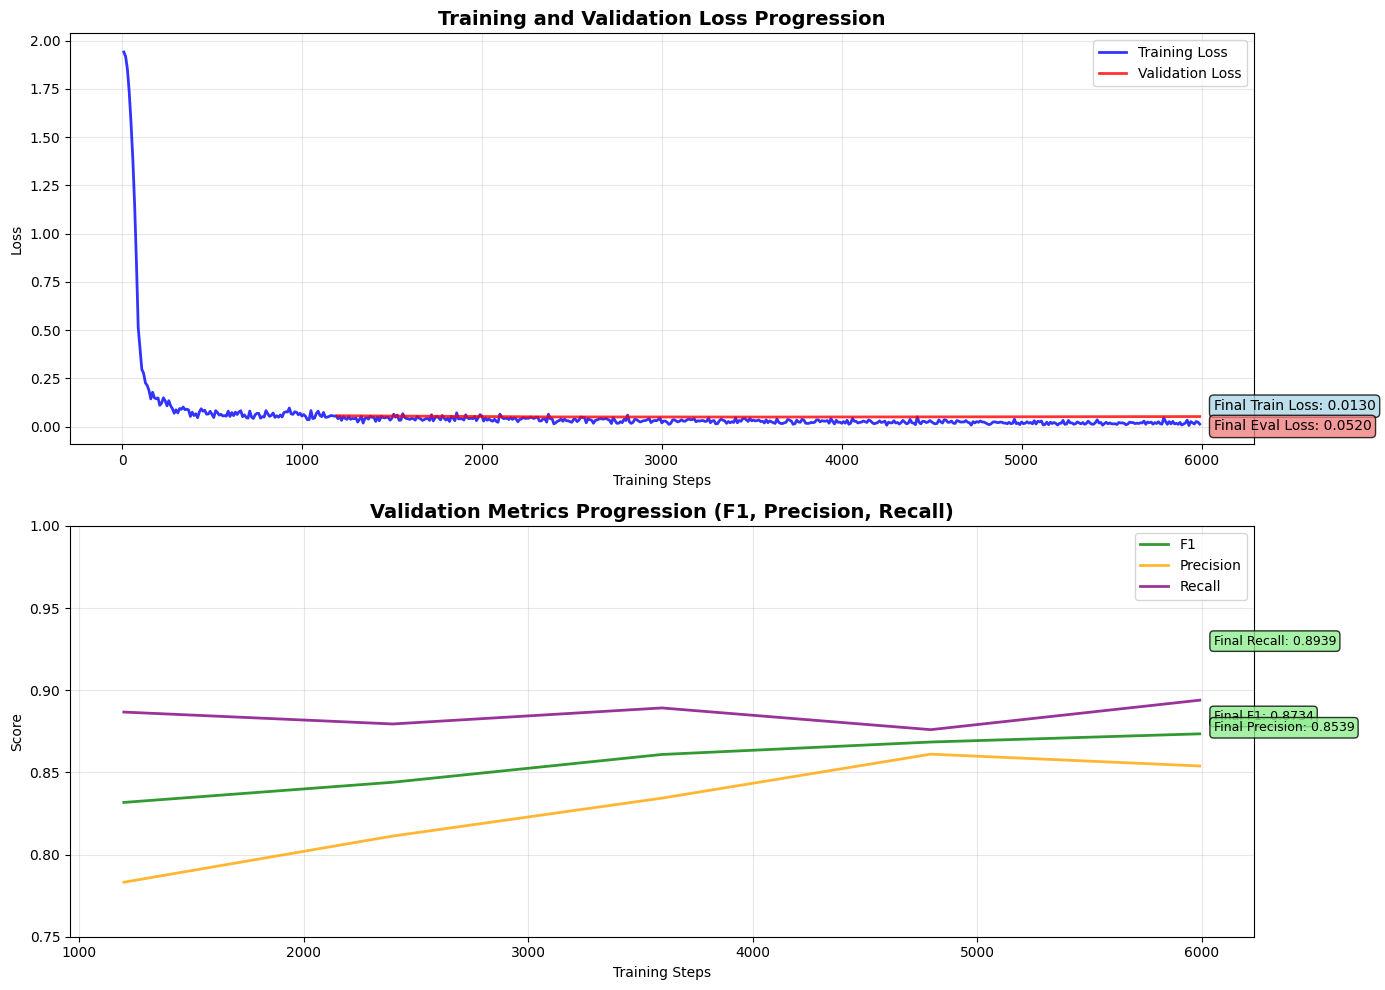

In [108]:
# %%

# Create figure with two subplots for loss and metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Training and Evaluation Loss
if 'loss' in df_history.columns and 'eval_loss' in df_history.columns:
    # Separate training and evaluation data
    train_data = df_history[['step', 'loss']].dropna()
    eval_data = df_history[['step', 'eval_loss']].dropna()
    
    if len(train_data) > 0:
        ax1.plot(train_data['step'], train_data['loss'], label='Training Loss', 
                linewidth=2, color='blue', alpha=0.8)
    
    if len(eval_data) > 0:
        ax1.plot(eval_data['step'], eval_data['eval_loss'], label='Validation Loss', 
                linewidth=2, color='red', alpha=0.8)
    
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss Progression', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add annotations for final values
    if len(train_data) > 0:
        final_train_loss = train_data['loss'].iloc[-1]
        ax1.annotate(f'Final Train Loss: {final_train_loss:.4f}', 
                    xy=(train_data['step'].iloc[-1], final_train_loss),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8),
                    fontsize=10)
    
    if len(eval_data) > 0:
        final_eval_loss = eval_data['eval_loss'].iloc[-1]
        ax1.annotate(f'Final Eval Loss: {final_eval_loss:.4f}', 
                    xy=(eval_data['step'].iloc[-1], final_eval_loss),
                    xytext=(10, -10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8),
                    fontsize=10)
else:
    ax1.text(0.5, 0.5, 'No loss data available', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Training and Validation Loss Progression')

# Plot 2: F1, Precision, and Recall Metrics
metrics_columns = ['eval_f1', 'eval_precision', 'eval_recall']
available_metrics = [col for col in metrics_columns if col in df_history.columns]

if available_metrics:
    # Filter out None values and convert to numeric
    df_metrics = df_history[['step'] + available_metrics].copy()
    df_metrics = df_metrics.dropna()
    
    if len(df_metrics) > 0:
        colors = ['green', 'orange', 'purple']
        for i, metric in enumerate(available_metrics):
            metric_name = metric.replace('eval_', '').title()
            ax2.plot(df_metrics['step'], df_metrics[metric], 
                    label=metric_name, linewidth=2, color=colors[i % len(colors)], alpha=0.8)
        
        ax2.set_xlabel('Training Steps')
        ax2.set_ylabel('Score')
        ax2.set_title('Validation Metrics Progression (F1, Precision, Recall)', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0.75, 1)  # Adjust based on your data range
        
        # Add annotations for final values
        for i, metric in enumerate(available_metrics):
            final_value = df_metrics[metric].iloc[-1] if len(df_metrics) > 0 else None
            if final_value is not None:
                metric_name = metric.replace('eval_', '').title()
                ax2.annotate(f'Final {metric_name}: {final_value:.4f}', 
                            xy=(df_metrics['step'].iloc[-1], final_value),
                            xytext=(10, 10 + i*15), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8),
                            fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'No metrics data available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Validation Metrics Progression')
else:
    ax2.text(0.5, 0.5, 'No evaluation metrics available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Validation Metrics Progression')

plt.tight_layout()
plt.show()

In [109]:
# %%

# Save the plots
plot_save_path = model_save_path_results / "training_progression_plots.png"
plt.savefig(plot_save_path, dpi=300, bbox_inches='tight')
print(f"Training progression plots saved to: {plot_save_path}")

Training progression plots saved to: c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\pretrained\distilbert_ner_finetuned\results\training_progression_plots.png


<Figure size 640x480 with 0 Axes>

In [110]:
# %%

# Create a comprehensive summary table of training progress
print("\n" + "="*80)
print("TRAINING PROGRESS SUMMARY")
print("="*80)

if len(df_history) > 0:
    # Get the last entry to show final metrics
    last_entry = df_history.iloc[-1]
    
    print(f"\n📊 Training Overview:")
    print(f"  Total Log Entries: {len(df_history)}")
    print(f"  Total Training Steps: {df_history['step'].max()}")
    print(f"  Training Epochs: {df_history['epoch'].max():.1f}")
    
    # Show final training metrics
    print(f"\n🎯 Final Training Metrics:")
    if 'train_loss' in df_history.columns:
        print(f"  Final Training Loss: {df_history['train_loss'].iloc[-1]:.6f}")
    if 'train_runtime' in df_history.columns:
        runtime_hours = df_history['train_runtime'].iloc[-1] / 3600
        print(f"  Total Training Time: {runtime_hours:.2f} hours")
    
    # Show final evaluation metrics
    print(f"\n📈 Final Evaluation Metrics:")
    eval_metrics = ['eval_loss', 'eval_f1', 'eval_precision', 'eval_recall']
    for metric in eval_metrics:
        if metric in df_history.columns:
            final_value = df_history[metric].iloc[-1]
            if pd.notna(final_value):
                metric_name = metric.replace('eval_', '').title()
                print(f"  {metric_name}: {final_value:.6f}")
    
    # Show progression analysis
    if len(df_history) > 1:
        print(f"\n📈 Training Progression Analysis:")
        
        # Loss progression
        if 'loss' in df_history.columns:
            train_loss_data = df_history[['step', 'loss']].dropna()
            if len(train_loss_data) > 0:
                initial_loss = train_loss_data['loss'].iloc[0]
                final_loss = train_loss_data['loss'].iloc[-1]
                loss_improvement = ((initial_loss - final_loss) / initial_loss) * 100
                
                print(f"  Training Loss:")
                print(f"    Initial: {initial_loss:.6f}")
                print(f"    Final: {final_loss:.6f}")
                print(f"    Improvement: {loss_improvement:.2f}%")
        
        # Evaluation loss progression
        if 'eval_loss' in df_history.columns:
            eval_loss_data = df_history[['step', 'eval_loss']].dropna()
            if len(eval_loss_data) > 0:
                initial_eval_loss = eval_loss_data['eval_loss'].iloc[0]
                final_eval_loss = eval_loss_data['eval_loss'].iloc[-1]
                eval_loss_improvement = ((initial_eval_loss - final_eval_loss) / initial_eval_loss) * 100
                
                print(f"  Validation Loss:")
                print(f"    Initial: {initial_eval_loss:.6f}")
                print(f"    Final: {final_eval_loss:.6f}")
                print(f"    Improvement: {eval_loss_improvement:.2f}%")
        
        # F1 score progression
        if 'eval_f1' in df_history.columns:
            f1_data = df_history[['step', 'eval_f1']].dropna()
            if len(f1_data) > 0:
                initial_f1 = f1_data['eval_f1'].iloc[0]
                final_f1 = f1_data['eval_f1'].iloc[-1]
                f1_improvement = ((final_f1 - initial_f1) / initial_f1) * 100 if initial_f1 > 0 else 0
                
                print(f"  F1 Score:")
                print(f"    Initial: {initial_f1:.6f}")
                print(f"    Final: {final_f1:.6f}")
                print(f"    Improvement: {f1_improvement:.2f}%")
        
        # Learning rate analysis
        if 'learning_rate' in df_history.columns:
            lr_data = df_history[['step', 'learning_rate']].dropna()
            if len(lr_data) > 0:
                initial_lr = lr_data['learning_rate'].iloc[0]
                final_lr = lr_data['learning_rate'].iloc[-1]
                print(f"  Learning Rate:")
                print(f"    Initial: {initial_lr:.2e}")
                print(f"    Final: {final_lr:.2e}")
                print(f"    Range: {lr_data['learning_rate'].min():.2e} - {lr_data['learning_rate'].max():.2e}")

else:
    print("❌ No training history data available")

print("\n" + "="*80)


TRAINING PROGRESS SUMMARY

📊 Training Overview:
  Total Log Entries: 606
  Total Training Steps: 5990
  Training Epochs: 5.0

🎯 Final Training Metrics:
  Final Training Loss: nan
  Total Training Time: nan hours

📈 Final Evaluation Metrics:
  Loss: 0.052000
  F1: 0.873443
  Precision: 0.853879
  Recall: 0.893925

📈 Training Progression Analysis:
  Training Loss:
    Initial: 1.941300
    Final: 0.013000
    Improvement: 99.33%
  Validation Loss:
    Initial: 0.056281
    Final: 0.052000
    Improvement: 7.61%
  F1 Score:
    Initial: 0.831709
    Final: 0.873443
    Improvement: 5.02%
  Learning Rate:
    Initial: 4.01e-07
    Final: 1.41e-08
    Range: 1.41e-08 - 2.00e-05

